In [106]:
from sympy import *
import numpy as np
from scipy.optimize import fsolve
from toolbox import Tools

tools = Tools()

V_POC, I11, I12, I21, I22, I31, I32, P1, P2, V_A1, V_A2, V_B, V_S1, V_S2, Z11, Z12, Z21, Z22, Z31, Z32, Z41, Z42, Z5, Z6 = symbols('V_POC I11 I12 I21 I22 I31 I32 P1 P2 V_A1 V_A2 V_B V_S1 V_S2 Z11 Z12 Z21 Z22 Z31 Z32 Z41 Z42 Z5 Z6')

init_printing(use_unicode=True)

# Open Circuit Voltages (Thevenin voltages)
### Turbine 1

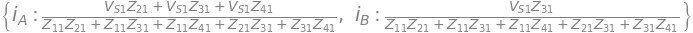

In [107]:
i_A, i_B, E1, Z11, Z21, Z31, Z41 = symbols('i_A i_B E1 Z11 Z21 Z31 Z41')

eqA = i_A * (Z11 + Z31) - i_B * Z31 - V_S1
eqB = i_A * (-Z31) + i_B * (Z31 + Z21 + Z41)

sol = solve([eqA, eqB], [i_A, i_B])
sol

In [108]:
# The output voltage is the current i_B times Z41
i = list(sol.values())
i_A = i[0]
i_B = i[1]
E1 = i_B * Z41
print(E1)

V_S1*Z31*Z41/(Z11*Z21 + Z11*Z31 + Z11*Z41 + Z21*Z31 + Z31*Z41)


### Turbine 2

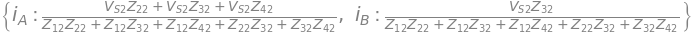

In [109]:
i_A, i_B, E2, Z12, Z22, Z32, Z42 = symbols('i_A i_B E2 Z12 Z22 Z32 Z42')
eqA = i_A * (Z12 + Z32) - i_B * Z32 - V_S2
eqB = i_A * (-Z32) + i_B * (Z32 + Z22 + Z42)

sol = solve([eqA, eqB], [i_A, i_B])
sol

In [110]:
# The output voltage is the current through Z41 times Z41
i = list(sol.values())
i_A = i[0]
i_B = i[1]
E2 = i_B * Z42
print(E2)

V_S2*Z32*Z42/(Z12*Z22 + Z12*Z32 + Z12*Z42 + Z22*Z32 + Z32*Z42)


### POC
For the POC branch, the open loop voltage is simply the POC voltage, since no current flows through Z5 with open loop conditions.

In [111]:
V_POC = symbols('V_POC')
E3 = V_POC
print(E3)


V_POC


# Thevenin Impedances
The Thevenin impedance can be found by turning off (shorting) the voltage source of the branch, and finding the equivalent impedance looking into the branch from the terminal.
### Turbine 1

In [112]:
Zth1 = (((Z21**-1 + Z31**-1)**-1 + Z21)**-1 + Z41**-1)**-1
print(Zth1)

1/(1/(Z21 + 1/(1/Z31 + 1/Z21)) + 1/Z41)


### Turbine 2

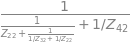

In [113]:
Zth2 = (((Z22**-1 + Z32**-1)**-1 + Z22)**-1 + Z42**-1)**-1
Zth2

### POC


In [114]:
Zth3 = Z5
Zth3

# Putting it together
The output voltage $V_B$ is the sum of the contributions from the three branches:
$V_B = V_{O1} + V_{O2} + V_{O3}$

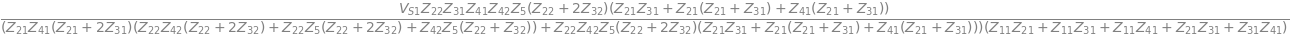

In [115]:
VO1 = (Zth2**-1 + Zth3**-1)**-1 / ((Zth2**-1 + Zth3**-1)**-1 + Zth1) * E1
VO1 = VO1.simplify()
VO1

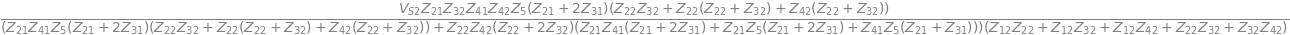

In [116]:
VO2 = (Zth1**-1 + Zth3**-1)**-1 / ((Zth1**-1 + Zth3**-1)**-1 + Zth2) * E2
VO2 = VO2.simplify()
VO2

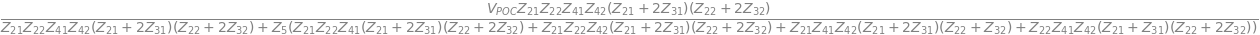

In [117]:
VO3 = (Zth1**-1 + Zth2**-1)**-1 / ((Zth1**-1 + Zth2**-1)**-1 + Zth3) * E3
VO3 = VO3.simplify()
VO3

In [118]:
V_B = VO1 + VO2 + VO3
print(V_B)

V_POC*Z21*Z22*Z41*Z42*(Z21 + 2*Z31)*(Z22 + 2*Z32)/(Z21*Z22*Z41*Z42*(Z21 + 2*Z31)*(Z22 + 2*Z32) + Z5*(Z21*Z22*Z41*(Z21 + 2*Z31)*(Z22 + 2*Z32) + Z21*Z22*Z42*(Z21 + 2*Z31)*(Z22 + 2*Z32) + Z21*Z41*Z42*(Z21 + 2*Z31)*(Z22 + Z32) + Z22*Z41*Z42*(Z21 + Z31)*(Z22 + 2*Z32))) + V_S1*Z22*Z31*Z41*Z42*Z5*(Z22 + 2*Z32)*(Z21*Z31 + Z21*(Z21 + Z31) + Z41*(Z21 + Z31))/((Z21*Z41*(Z21 + 2*Z31)*(Z22*Z42*(Z22 + 2*Z32) + Z22*Z5*(Z22 + 2*Z32) + Z42*Z5*(Z22 + Z32)) + Z22*Z42*Z5*(Z22 + 2*Z32)*(Z21*Z31 + Z21*(Z21 + Z31) + Z41*(Z21 + Z31)))*(Z11*Z21 + Z11*Z31 + Z11*Z41 + Z21*Z31 + Z31*Z41)) + V_S2*Z21*Z32*Z41*Z42*Z5*(Z21 + 2*Z31)*(Z22*Z32 + Z22*(Z22 + Z32) + Z42*(Z22 + Z32))/((Z21*Z41*Z5*(Z21 + 2*Z31)*(Z22*Z32 + Z22*(Z22 + Z32) + Z42*(Z22 + Z32)) + Z22*Z42*(Z22 + 2*Z32)*(Z21*Z41*(Z21 + 2*Z31) + Z21*Z5*(Z21 + 2*Z31) + Z41*Z5*(Z21 + Z31)))*(Z12*Z22 + Z12*Z32 + Z12*Z42 + Z22*Z32 + Z32*Z42))


# fsolve()


In [119]:
def equations(VS, *args):
    P1, P2 = args
    V_POC = 4e3

    V_S1 = VS[0] + 1j * VS[1]
    V_S2 = VS[2] + 1j * VS[3]

    Z11, Z12, Z21, Z22, Z31, Z32, Z41, Z42, Z5, Z6 = tools.get_impedances(verb=False)

    E1 = V_S2*Z32*Z41/(Z12*Z22 + Z12*Z32 + Z12*Z42 + Z22*Z32 + Z32*Z42)
    E2 = V_S2*Z32*Z42/(Z12*Z22 + Z12*Z32 + Z12*Z42 + Z22*Z32 + Z32*Z42)

    Zth1 = 1/(1/(Z21 + 1/(1/Z31 + 1/Z21)) + 1/Z41)
    Zth2 = 1/(1/(Z22 + 1/(1/Z32 + 1/Z22)) + 1/Z42)

    V_B = V_POC*Z21*Z22*Z41*Z42*(Z21 + 2*Z31)*(Z22 + 2*Z32)/(Z21*Z22*Z41*Z42*(Z21 + 2*Z31)*(Z22 + 2*Z32) + Z5*(Z21*Z22*Z41*(Z21 + 2*Z31)*(Z22 + 2*Z32) + Z21*Z22*Z42*(Z21 + 2*Z31)*(Z22 + 2*Z32) + Z21*Z41*Z42*(Z21 + 2*Z31)*(Z22 + Z32) + Z22*Z41*Z42*(Z21 + Z31)*(Z22 + 2*Z32))) + V_S1*Z22*Z31*Z41*Z42*Z5*(Z22 + 2*Z32)*(Z21*Z31 + Z21*(Z21 + Z31) + Z41*(Z21 + Z31))/((Z21*Z41*(Z21 + 2*Z31)*(Z22*Z42*(Z22 + 2*Z32) + Z22*Z5*(Z22 + 2*Z32) + Z42*Z5*(Z22 + Z32)) + Z22*Z42*Z5*(Z22 + 2*Z32)*(Z21*Z31 + Z21*(Z21 + Z31) + Z41*(Z21 + Z31)))*(Z11*Z21 + Z11*Z31 + Z11*Z41 + Z21*Z31 + Z31*Z41)) + V_S2*Z21*Z32*Z41*Z42*Z5*(Z21 + 2*Z31)*(Z22*Z32 + Z22*(Z22 + Z32) + Z42*(Z22 + Z32))/((Z21*Z41*Z5*(Z21 + 2*Z31)*(Z22*Z32 + Z22*(Z22 + Z32) + Z42*(Z22 + Z32)) + Z22*Z42*(Z22 + 2*Z32)*(Z21*Z41*(Z21 + 2*Z31) + Z21*Z5*(Z21 + 2*Z31) + Z41*Z5*(Z21 + Z31)))*(Z12*Z22 + Z12*Z32 + Z12*Z42 + Z22*Z32 + Z32*Z42))

    eq1 = E1 * (E1 - V_B) / Zth1 - P1
    eq2 = E2 * (E2 - V_B) / Zth2 - P2

    return np.array([eq1.real, eq1.imag, eq2.real, eq2.imag])

In [120]:
init_guess = np.array([10e3, 0, 10e3, 0])
powers = (3e6, 3e6)
sol = fsolve(func=equations, x0=init_guess, args=powers)

In [121]:
sol

array([-10856.08604502,  -1094.54996987,    164.02649925,   -440.4516142 ])